# **ARIMA-Based Time Series Forecasting Simulator**

How It Works

1. Load Data: Reads the sensor data from a CSV file.
2.	Preprocess Data: Converts timestamps to datetime format and resamples to hourly data.
3.	Check Stationarity: Runs the Augmented Dickey-Fuller (ADF) test to check if differencing is needed.
4.	Fit ARIMA Model: Uses (p=5, d=1, q=0) as an example (can be optimized).
5.	Forecast: Predicts the next 24 hours of sensor readings.
6.	Visualization: Plots both historical data and future predictions.

### **Step 1: Install Required Libraries**

In [ ]:
# Install dependencies
%pip install statsmodels pandas numpy matplotlib scikit-learn pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 487.8 kB/s eta 0:00:00a 0:00:01


### **Step 2: Import Libraries**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm  # Auto ARIMA optimization
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import ks_2samp, entropy

### **Step 3: Import Sensor Data CSV file**

In [6]:
# Replace "sensor_data.csv" with your actual dataset file
df = pd.read_csv("../databases/processed_data/cd230831.csv")

# Convert 'datetime' column to pandas datetime format and set as index
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

In [7]:
print(df.columns)

Index(['cooling_channel0', 'cooling_channel1', 'cooling_channel10',
       'cooling_channel11', 'maxigauge_channel1', 'maxigauge_channel2',
       'maxigauge_channel3', 'maxigauge_channel4', 'maxigauge_channel5',
       'maxigauge_channel6', 'temperature_channel1', 'temperature_channel2',
       'temperature_channel5', 'temperature_channel6'],
      dtype='object')


In [8]:
df

cooling_channel0  cooling_channel1  cooling_channel10  \
datetime                                                                     
2023-08-31 00:00:30         15.596670         15.558330          15.542780   
2023-08-31 00:01:00         15.594503         15.558330          15.538204   
2023-08-31 00:01:30         15.592003         15.558330          15.532924   
2023-08-31 00:02:00         15.590465         15.553758          15.537758   
2023-08-31 00:02:30         15.589075         15.548483          15.544148   
...                               ...               ...                ...   
2023-09-23 23:54:00         15.617176         15.581013          15.533379   
2023-09-23 23:54:30         15.608149         15.574485          15.525739   
2023-09-23 23:55:00         15.599121         15.567958          15.518099   
2023-09-23 23:55:30         15.590094         15.561430          15.510459   
2023-09-23 23:56:00         15.588890         15.560560          15.509440   

                     cooling_channel11  maxigauge_channel1  \
datetime                                                     
2023-08-31 00:00:30          15.555560                0.02   
2023-08-31 00:01:00          15.546651                0.02   
2023-08-31 00:01:30          15.536371                0.02   
2023-08-31 00:02:00          15.549443                0.02   
2023-08-31 00:02:30          15.566108                0.02   
...                                ...                 ...   
2023-09-23 23:54:00          15.560624                0.02   
2023-09-23 23:54:30          15.554929                0.02   
2023-09-23 23:55:00          15.549234                 NaN   
2023-09-23 23:55:30          15.543539                 NaN   
2023-09-23 23:56:00          15.542780                 NaN   

                     maxigauge_channel2  maxigauge_channel3  \
datetime                                                      
2023-08-31 00:00:30            0.088700           -1.480000   
2023-08-31 00:01:00            0.088713           -1.474754   
2023-08-31 00:01:30            0.088762           -1.455082   
2023-08-31 00:02:00            0.088800           -1.440000   
2023-08-31 00:02:30            0.088800           -1.440000   
...                                 ...                 ...   
2023-09-23 23:54:00            0.010300           -0.385098   
2023-09-23 23:54:30            0.010300           -0.375000   
2023-09-23 23:55:00                 NaN                 NaN   
2023-09-23 23:55:30                 NaN                 NaN   
2023-09-23 23:56:00                 NaN                 NaN   

                     maxigauge_channel4  maxigauge_channel5  \
datetime                                                      
2023-08-31 00:00:30               150.0          710.000000   
2023-08-31 00:01:00               150.0          710.000000   
2023-08-31 00:01:30               150.0          710.000000   
2023-08-31 00:02:00               150.0          710.000000   
2023-08-31 00:02:30               150.0          710.000000   
...                                 ...                 ...   
2023-09-23 23:54:00               613.0          721.180328   
2023-09-23 23:54:30               613.0          721.000000   
2023-09-23 23:55:00                 NaN                 NaN   
2023-09-23 23:55:30                 NaN                 NaN   
2023-09-23 23:56:00                 NaN                 NaN   

                     maxigauge_channel6  temperature_channel1  \
datetime                                                        
2023-08-31 00:00:30             998.000            293.079000   
2023-08-31 00:01:00             998.000            293.079033   
2023-08-31 00:01:30             998.000            293.080033   
2023-08-31 00:02:00             998.000            293.080951   
2023-08-31 00:02:30             998.000            293.079475   
...                                 ...                   ...   
2023-09-23 23:54:00               0.862

In [5]:
# Select relevant sensor channels for ARIMA modeling
selected_channels = ["cooling_channel10", "temperature_channel1", "maxigauge_channel3"]

### **Step 4: Check for Stationarity**

In [6]:
def check_stationarity(series):
    adf_test = adfuller(series.dropna())
    print(f"ADF Statistic: {adf_test[0]}, P-value: {adf_test[1]}")
    if adf_test[1] > 0.05:
        print("Data is NOT stationary, applying differencing...")
        return series.diff().dropna()
    else:
        print("Data is already stationary.")
        return series

### **Step 5: Determine Optimal ARIMA Parameters**

In [7]:
def find_best_arima_params(series):
    auto_arima_model = pm.auto_arima(series, seasonal=False, stepwise=True, suppress_warnings=True, trace=True)
    return auto_arima_model.order  # Returns optimal (p, d, q)

### **Step 6: Train ARIMA Model**

In [8]:
forecast_results = {}


Processing ARIMA for cooling_channel10
ADF Statistic: -2.7622966706219945, P-value: 0.06386450990442394
Data is NOT stationary, applying differencing...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-378489.507, Time=15.99 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-350467.256, Time=2.96 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-352167.054, Time=3.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-357922.436, Time=7.83 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-350469.256, Time=0.87 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-375903.633, Time=3.55 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-365066.381, Time=4.97 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-379320.624, Time=33.45 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-365349.424, Time=20.03 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-371300.542, Time=30.02 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-379074.979, Time=20.81 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : A

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Evaluation Metrics for cooling_channel10:
Mean Absolute Error (MAE): 0.01
Root Mean Squared Error (RMSE): 0.03
Kolmogorov-Smirnov Statistic: 0.5120, p-value: 0.0000
Kullback-Leibler Divergence: inf


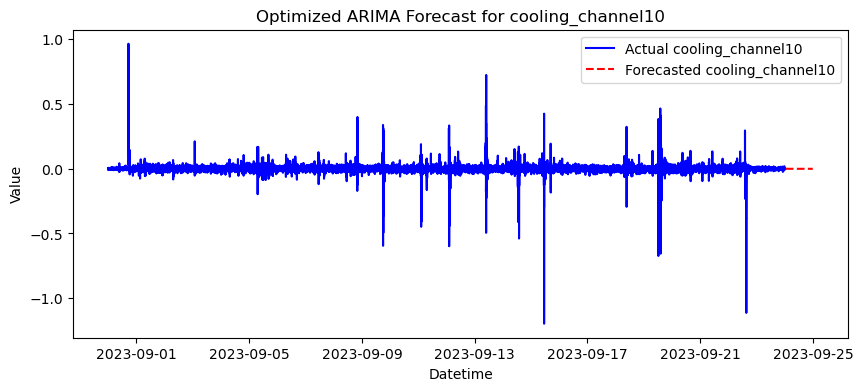


Processing ARIMA for temperature_channel1
ADF Statistic: -2.6153976226661535, P-value: 0.08985646709139655
Data is NOT stationary, applying differencing...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-433995.654, Time=26.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-422305.517, Time=2.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-422598.989, Time=2.77 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-422931.503, Time=5.67 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-422307.517, Time=0.93 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-409372.772, Time=18.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-436643.149, Time=17.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-432305.695, Time=10.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-427324.313, Time=3.43 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-431838.571, Time=20.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-428738.579, Time=4.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stati


Evaluation Metrics for temperature_channel1:
Mean Absolute Error (MAE): 0.02
Root Mean Squared Error (RMSE): 0.06
Kolmogorov-Smirnov Statistic: 0.7091, p-value: 0.0000
Kullback-Leibler Divergence: inf


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


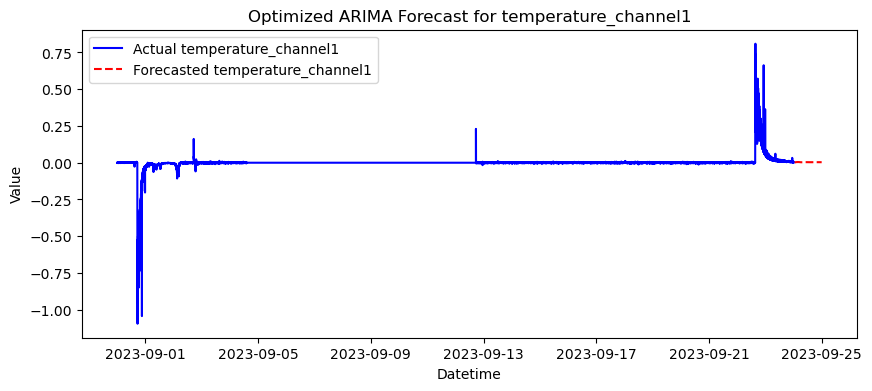


Processing ARIMA for maxigauge_channel3
ADF Statistic: -3.5538588727435028, P-value: 0.00670694789671036
Data is already stationary.
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=267822.013, Time=16.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=351834.411, Time=0.48 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=284980.179, Time=1.29 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=286626.124, Time=4.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=351832.411, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=269698.869, Time=6.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=268422.780, Time=4.24 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=267931.016, Time=28.78 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=267816.919, Time=15.31 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=268600.048, Time=5.96 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=267796.071, Time=13.61 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=267574.651, Time=30.40 sec
 A

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: Us


Evaluation Metrics for maxigauge_channel3:
Mean Absolute Error (MAE): 503.95
Root Mean Squared Error (RMSE): 594.73
Kolmogorov-Smirnov Statistic: 0.7255, p-value: 0.0000
Kullback-Leibler Divergence: inf


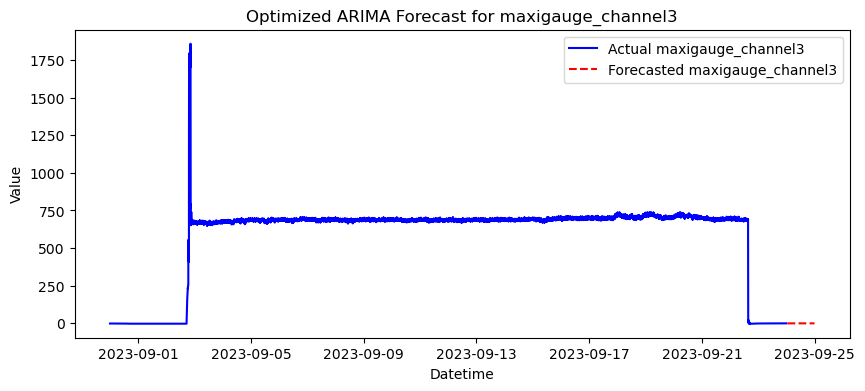

In [9]:
for sensor in selected_channels:
    print(f"\nProcessing ARIMA for {sensor}")
    
    data = df[sensor].dropna()
    
    # Step 4: Check and adjust for stationarity
    data = check_stationarity(data)

    # Step 5: Find optimal ARIMA parameters
    best_order = find_best_arima_params(data)
    print(f"Optimal ARIMA Order for {sensor}: {best_order}")
    
    # Step 6: Train ARIMA model
    model = ARIMA(data, order=best_order)
    model_fit = model.fit()
    
    # Step 7: Forecast next 24 hours
    forecast = model_fit.forecast(steps=24)
    forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(hours=1), periods=24, freq='h')
    forecast_df = pd.DataFrame({'Forecasted Values': forecast.values}, index=forecast_index)
    
    # Store forecast results
    forecast_results[sensor] = forecast_df

    # Step 8: Evaluate Model Performance
    train_size = int(len(data) * 0.8)
    train, test = data[:train_size], data[train_size:]
    forecast_test = model_fit.forecast(steps=len(test))

    # Calculate MAE and RMSE
    mae = mean_absolute_error(test, forecast_test)
    rmse = np.sqrt(mean_squared_error(test, forecast_test))
    
    # KS test
    ks_stat, ks_p_value = ks_2samp(test, forecast_test)

    # KL Divergence (requires nonzero values)
    test_nonzero = test + 1e-10  # Avoid log(0)
    forecast_nonzero = forecast_test + 1e-10
    kl_divergence = entropy(test_nonzero, forecast_nonzero)

    # Print evaluation metrics
    print(f"\nEvaluation Metrics for {sensor}:")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Kolmogorov-Smirnov Statistic: {ks_stat:.4f}, p-value: {ks_p_value:.4f}")
    print(f"Kullback-Leibler Divergence: {kl_divergence:.4f}")

    # Plot actual vs. forecasted values
    plt.figure(figsize=(10, 4))
    plt.plot(data, label=f"Actual {sensor}", color='blue')
    plt.plot(forecast_df, label=f"Forecasted {sensor}", color='red', linestyle='dashed')
    plt.xlabel("Datetime")
    plt.ylabel("Value")
    plt.title(f"Optimized ARIMA Forecast for {sensor}")
    plt.legend()
    plt.show()


# Arimax

## Arimax for selected sensors channels
'cooling_channel0', 'maxigauge_channel3', 'maxigauge_channel5', 'temperature_channel1', 'temperature_channel6'

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import joblib
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller

In [2]:
# Load dataset
df = pd.read_csv("../databases/processed_data/cd230831.csv")
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

In [13]:
# Selected channels based on correlation analysis
selected_channels = ['cooling_channel0', 'maxigauge_channel3', 'maxigauge_channel5', 'temperature_channel1', 'temperature_channel6']

In [14]:
# Handle missing values
df.interpolate(method='linear', inplace=True)

In [15]:
# Outlier detection using IQR with capping
def cap_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

df = cap_outliers(df, selected_channels)

In [16]:
df

cooling_channel0  cooling_channel1  cooling_channel10  \
datetime                                                                     
2023-09-03 21:45:00         29.124640         18.320625          27.834515   
2023-09-03 22:01:00         29.143276         18.281469          27.866280   
2023-09-03 22:01:30         29.148367         18.283597          27.875355   
2023-09-03 22:02:00         29.153459         18.285726          27.884430   
2023-09-03 22:02:30         29.158551         18.287854          27.893505   
...                               ...               ...                ...   
2023-09-22 15:15:30         28.645369         19.825090          27.663537   
2023-09-22 15:16:00         28.656481         19.831016          27.674741   
2023-09-22 15:16:30         28.667139         19.838606          27.688126   
2023-09-22 15:17:00         28.676303         19.851661          27.708681   
2023-09-22 15:17:30         28.398274         19.859164          27.464641   

                     cooling_channel11  maxigauge_channel1  \
datetime                                                     
2023-09-03 21:45:00          18.388046            0.000009   
2023-09-03 22:01:00          18.475992            0.000009   
2023-09-03 22:01:30          18.482010            0.000009   
2023-09-03 22:02:00          18.488028            0.000009   
2023-09-03 22:02:30          18.494047            0.000009   
...                                ...                 ...   
2023-09-22 15:15:30          19.877736            0.000005   
2023-09-22 15:16:00          19.881531            0.000005   
2023-09-22 15:16:30          19.883273            0.000005   
2023-09-22 15:17:00          19.878273            0.000005   
2023-09-22 15:17:30          19.875240            0.000005   

                     maxigauge_channel2  maxigauge_channel3  \
datetime                                                      
2023-09-03 21:45:00            0.022300          680.000000   
2023-09-03 22:01:00            0.022238          666.903239   
2023-09-03 22:01:30            0.022254          667.434783   
2023-09-03 22:02:00            0.022271          669.065217   
2023-09-03 22:02:30            0.022287          670.695652   
...                                 ...                 ...   
2023-09-22 15:15:30            0.022700          690.581967   
2023-09-22 15:16:00            0.022700          691.811475   
2023-09-22 15:16:30            0.022700          692.951613   
2023-09-22 15:17:00            0.022700          691.500000   
2023-09-22 15:17:30            0.022700          690.048387   

                     maxigauge_channel4  maxigauge_channel5  \
datetime                                                      
2023-09-03 21:45:00          699.000000            5.964973   
2023-09-03 22:01:00          690.282609            5.990000   
2023-09-03 22:01:30          691.260870            5.990000   
2023-09-03 22:02:00          692.239130            5.990000   
2023-09-03 22:02:30          693.217391            5.990000   
...                                 ...                 ...   
2023-09-22 15:15:30          712.000000            5.954836   
2023-09-22 15:16:00          712.000000            5.952377   
2023-09-22 15:16:30          712.016129            5.949839   
2023-09-22 15:17:00          712.500000            5.945000   
2023-09-22 15:17:30          712.983871            5.940161   

                     maxigauge_channel6  temperature_channel1  \
datetime                                                        
2023-09-03 21:45:00            0.009030             35.786433   
2023-09-03 22:01:00            0.009170             35.795580   
2023-09-03 22:01:30            0.009170             35.793480   
2023-09-03 22:02:00            0.009170             35.791380   
2023-09-03 22:02:30            0.009170             35.789280   
...                                 ...                   ...   
2023-09-22 15:15:30            7.979672

In [19]:
# Check for stationarity and apply differencing if necessary
def check_stationarity(series):
    result = adfuller(series.dropna())
    return result[1] < 0.05  # True if stationary

def make_stationary(series):
    return series.diff().dropna()

for channel in selected_channels:
    is_stationary = check_stationarity(df[channel])
    print(f"{channel} is {'stationary' if is_stationary else 'non-stationary'}")
    if not is_stationary:
        df[channel] = make_stationary(df[channel])

cooling_channel0 is stationary
maxigauge_channel3 is stationary
maxigauge_channel5 is stationary
temperature_channel1 is stationary
temperature_channel6 is stationary


In [20]:
# Train-test split
def train_test_split(series, split_ratio=0.8):
    split = int(len(series) * split_ratio)
    return series[:split], series[split:]

In [21]:
# Train ARIMAX models with validation
def fit_arimax_models(data, target_channel, exog_channels):
    models = {}
    target_series = data[target_channel].dropna()
    exog_data = data[exog_channels].dropna()
    target_series, exog_data = target_series.align(exog_data, join='inner')
    
    if len(target_series) == 0 or len(exog_data) == 0:
        print(f"Skipping {target_channel}: No aligned data")
        return {}
    
    train, test = train_test_split(target_series)
    exog_train, exog_test = train_test_split(exog_data)
    
    model = auto_arima(train, exogenous=exog_train, seasonal=True, stepwise=True, suppress_warnings=True, trace=True)
    models[target_channel] = model
    
    forecast = model.predict(n_periods=len(test), exogenous=exog_test)
    mae = mean_absolute_error(test, forecast)
    print(f"Validation MAE for {target_channel}: {mae:.2f}")
    
    return models

In [22]:
# Define relationships between dependent and independent variables
target_exog_pairs = {
    'temperature_channel1': ['temperature_channel6'],
    'cooling_channel0': ['maxigauge_channel3', 'maxigauge_channel5']
}

In [23]:
# Train ARIMAX models for each dependent variable
models = {}
for target, exog in target_exog_pairs.items():
    models.update(fit_arimax_models(df, target, exog))

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-422802.823, Time=9.96 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-397678.860, Time=1.72 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-416695.423, Time=2.21 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-416393.902, Time=3.38 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-397672.952, Time=0.52 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-422758.671, Time=5.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-422716.084, Time=4.14 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-422786.235, Time=10.39 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-422567.433, Time=19.51 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-422734.571, Time=3.46 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-422688.497, Time=3.90 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-422703.166, Time=9.23 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-422578.245, Time=20.46 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-422804.264, Ti

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-197184.158, Time=2.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-178807.075, Time=1.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-193595.770, Time=1.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-195964.259, Time=3.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-178809.051, Time=0.42 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-197037.237, Time=3.70 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-196999.028, Time=6.71 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-197106.997, Time=12.59 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-197381.052, Time=4.88 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-196966.216, Time=9.20 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-197364.351, Time=8.90 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-197394.503, Time=17.83 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-197236.655, Time=9.49 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=-197380.780, Time=20.91 sec
 ARIMA(2,1,5)(0,0,0)[0] interce

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
# Save models
joblib.dump(models, 'arimax_models.pkl')

In [24]:
# Simulate future exogenous variables
exog_models = {}
simulated_exog = pd.DataFrame()
forecast_steps = 24

for exog in set([ex for ex_list in target_exog_pairs.values() for ex in ex_list]):
    model = auto_arima(df[exog].dropna(), seasonal=True, stepwise=True, suppress_warnings=True)
    exog_models[exog] = model
    simulated_exog[exog] = model.predict(n_periods=forecast_steps)

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an 

In [25]:
# Generate simulated data
simulated_data = pd.DataFrame()
for target, exog in target_exog_pairs.items():
    forecast, conf_int = models[target].predict(n_periods=forecast_steps, exogenous=simulated_exog[exog], return_conf_int=True)
    simulated_data[target] = forecast
    simulated_data[f"{target}_lower"] = conf_int[:, 0]
    simulated_data[f"{target}_upper"] = conf_int[:, 1]

# Visualize simulated results with confidence intervals
fig = go.Figure()
for target in target_exog_pairs.keys():
    fig.add_trace(go.Scatter(x=df.index, y=df[target].dropna(), mode='lines', name=f'Original {target}'))
    fig.add_trace(go.Scatter(x=pd.date_range(start=df.index[-1], periods=forecast_steps, freq='D'),
                             y=simulated_data[target], mode='lines', name=f'Simulated {target}', line=dict(dash='dot')))
    fig.add_trace(go.Scatter(x=pd.date_range(start=df.index[-1], periods=forecast_steps, freq='D'),
                             y=simulated_data[f"{target}_lower"], mode='lines', name=f'Lower Bound {target}', line=dict(color='gray')))
    fig.add_trace(go.Scatter(x=pd.date_range(start=df.index[-1], periods=forecast_steps, freq='D'),
                             y=simulated_data[f"{target}_upper"], mode='lines', name=f'Upper Bound {target}', line=dict(color='gray'), fill='tonexty'))

fig.update_layout(title="Simulated Sensor Data with ARIMAX", xaxis_title="Time", yaxis_title="Sensor Reading")
fig.show()

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an 

In [ ]:
# Export simulated data to CSV
simulated_data.to_csv('simulated_sensor_data.csv', index=False)
print("Sensor data simulation completed using ARIMAX with improvements.")

## Arimax for all sensors channels

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import joblib
import logging
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller

In [ ]:
# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load all datasets from processed_data directory
def load_data():
    datasets = {}
    dataset_names = ['cd230831', 'cd230926', 'cd240111']
    
    for name in dataset_names:
        df = pd.read_csv(f"../databases/processed_data/{name}.csv")
        df['datetime'] = pd.to_datetime(df['datetime'])
        df.set_index('datetime', inplace=True)
        datasets[name] = df
        logging.info(f"Loaded {name}.csv with {df.shape[0]} rows.")
    
    return datasets

datasets = load_data()

2025-03-13 13:22:02,280 - INFO - Loaded cd230831.csv with 69112 rows.
2025-03-13 13:22:02,304 - INFO - Loaded cd230926.csv with 25911 rows.
2025-03-13 13:22:02,328 - INFO - Loaded cd240111.csv with 25909 rows.


In [28]:
# Concatenate time series datasets ensuring correct time alignment
all_data = pd.concat([datasets['cd230831'], datasets['cd230926'], datasets['cd240111']], axis=0).sort_index()

# Handle missing values
all_data.interpolate(method='linear', inplace=True)

In [29]:
# Improved Outlier Handling
def cap_outliers(df):
    for column in df.columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

all_data = cap_outliers(all_data)

In [30]:
# Check for stationarity and apply differencing if necessary
def check_stationarity(series):
    result = adfuller(series.dropna())
    return result[1] < 0.05

def make_stationary(series):
    return series.diff().dropna()

for column in all_data.columns:
    if not check_stationarity(all_data[column]):
        all_data[column] = make_stationary(all_data[column])
        logging.info(f"Applied differencing to {column} to ensure stationarity.")

2025-03-13 13:23:45,299 - INFO - Applied differencing to maxigauge_channel1 to ensure stationarity.
2025-03-13 13:24:46,725 - INFO - Applied differencing to maxigauge_channel5 to ensure stationarity.
2025-03-13 13:25:20,110 - INFO - Applied differencing to temperature_channel1 to ensure stationarity.
2025-03-13 13:25:36,108 - INFO - Applied differencing to temperature_channel2 to ensure stationarity.
2025-03-13 13:25:51,747 - INFO - Applied differencing to temperature_channel5 to ensure stationarity.


In [32]:
# Train-test split
def train_test_split(series, split_ratio=0.8):
    split = int(len(series) * split_ratio)
    return series[:split], series[split:]

# Define ARIMAX relationships
target_exog_pairs = {
    'temperature_channel1': ['temperature_channel2', 'temperature_channel5', 'temperature_channel6'],
    'cooling_channel0': ['cooling_channel1', 'cooling_channel10', 'cooling_channel11'],
    'maxigauge_channel3': ['maxigauge_channel1', 'maxigauge_channel2', 'maxigauge_channel4', 'maxigauge_channel5', 'maxigauge_channel6']
}

In [33]:
# Train ARIMAX models
def fit_arimax_models(data, target, exog):
    models = {}
    target_series = data[target].dropna()
    exog_data = data[exog].dropna()
    target_series, exog_data = target_series.align(exog_data, join='inner')
    
    if len(target_series) == 0 or len(exog_data) == 0:
        logging.warning(f"Skipping {target}: No aligned data")
        return {}
    
    train, test = train_test_split(target_series)
    exog_train, exog_test = train_test_split(exog_data)
    
    model = auto_arima(train, exogenous=exog_train, seasonal=True, m=12, stepwise=True, suppress_warnings=True, trace=True)
    models[target] = model
    
    forecast, conf_int = model.predict(n_periods=len(test), exogenous=exog_test, return_conf_int=True)
    mae = mean_absolute_error(test, forecast)
    logging.info(f"Validation MAE for {target}: {mae:.2f}")
    
    return models

models = {}
for target, exog in target_exog_pairs.items():
    models.update(fit_arimax_models(all_data, target, exog))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-725870.228, Time=82.57 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-690759.446, Time=1.78 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-697028.161, Time=10.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-716599.407, Time=50.23 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-690761.446, Time=1.06 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-726153.297, Time=83.23 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-726804.253, Time=24.92 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-726233.007, Time=98.17 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=-723501.004, Time=16.81 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=-723636.144, Time=7.70 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=-725938.637, Time=16.43 sec
 ARIMA(2,1,3)(0,0,0)[12] intercept   : AIC=-725289.078, Time=13.21 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-720084.550, Time=14.31 sec
 ARIMA(1,1,3)(0,0,0)[12] intercept   

: 

In [ ]:
# Save models
joblib.dump(models, 'arimax_all_sensors.pkl')

In [ ]:
# Simulate future data with exogenous variables
def simulate_future_data(models, data, target_exog_pairs, forecast_steps=24):
    simulated_data = pd.DataFrame()
    for target, exog in target_exog_pairs.items():
        exog_future = data[exog][-forecast_steps:].dropna()
        forecast, conf_int = models[target].predict(n_periods=forecast_steps, exogenous=exog_future, return_conf_int=True)
        simulated_data[target] = forecast
        simulated_data[f"{target}_lower"] = conf_int[:, 0]
        simulated_data[f"{target}_upper"] = conf_int[:, 1]
    return simulated_data

simulated_data = simulate_future_data(models, all_data, target_exog_pairs)

In [ ]:
# Visualize simulated results with confidence intervals
fig = go.Figure()
for target in target_exog_pairs.keys():
    fig.add_trace(go.Scatter(x=all_data.index, y=all_data[target].dropna(), mode='lines', name=f'Original {target}'))
    fig.add_trace(go.Scatter(x=pd.date_range(start=all_data.index[-1], periods=24, freq='D'),
                             y=simulated_data[target], mode='lines', name=f'Simulated {target}', line=dict(dash='dot')))
    fig.add_trace(go.Scatter(x=pd.date_range(start=all_data.index[-1], periods=24, freq='D'),
                             y=simulated_data[f"{target}_lower"], mode='lines', name=f'Lower Bound {target}', line=dict(color='gray')))
    fig.add_trace(go.Scatter(x=pd.date_range(start=all_data.index[-1], periods=24, freq='D'),
                             y=simulated_data[f"{target}_upper"], mode='lines', name=f'Upper Bound {target}', line=dict(color='gray'), fill='tonexty'))

fig.update_layout(title="Simulated Sensor Data with ARIMAX", xaxis_title="Time", yaxis_title="Sensor Reading")
fig.show()

In [ ]:
# Export simulated data
simulated_data.to_csv('simulated_sensor_data_all.csv', index=False)
logging.info("Simulation for all sensor channels completed.")

## multi-stage ARIMAX approach
implement a hierarchical ARIMA approach, where you first model each sensor type independently and then combine them into a final ARIMAX model for an overall sensor simulator.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import joblib
import logging
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller

In [2]:
# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load all datasets from processed_data directory
def load_data():
    datasets = {}
    dataset_names = ['cd230831', 'cd230926', 'cd240111']
    
    for name in dataset_names:        
        df = pd.read_csv(f"../databases/processed_data/{name}.csv")
        df['datetime'] = pd.to_datetime(df['datetime'])
        df.set_index('datetime', inplace=True)
        datasets[name] = df
        logging.info(f"Loaded {name}.csv with {df.shape[0]} rows.")
    
    return datasets

datasets = load_data()

2025-03-13 14:09:26,519 - INFO - Loaded cd230831.csv with 69112 rows.
2025-03-13 14:09:26,544 - INFO - Loaded cd230926.csv with 25911 rows.
2025-03-13 14:09:26,569 - INFO - Loaded cd240111.csv with 25909 rows.


In [3]:
# Concatenate time series datasets ensuring correct time alignment
all_data = pd.concat([datasets['cd230831'], datasets['cd230926'], datasets['cd240111']], axis=0).sort_index()

# Handle missing values
all_data.interpolate(method='linear', inplace=True)

# Improved Outlier Handling
def cap_outliers(df):
    for column in df.columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

all_data = cap_outliers(all_data)

In [4]:
# Check for stationarity and apply differencing if necessary
def check_stationarity(series):
    result = adfuller(series.dropna())
    return result[1] < 0.05

def make_stationary(series):
    return series.diff().dropna()

for column in all_data.columns:
    if not check_stationarity(all_data[column]):
        all_data[column] = make_stationary(all_data[column])
        logging.info(f"Applied differencing to {column} to ensure stationarity.")

2025-03-13 14:10:44,059 - INFO - Applied differencing to maxigauge_channel1 to ensure stationarity.
2025-03-13 14:11:46,342 - INFO - Applied differencing to maxigauge_channel5 to ensure stationarity.
2025-03-13 14:12:23,640 - INFO - Applied differencing to temperature_channel1 to ensure stationarity.
2025-03-13 14:12:41,933 - INFO - Applied differencing to temperature_channel2 to ensure stationarity.
2025-03-13 14:12:57,896 - INFO - Applied differencing to temperature_channel5 to ensure stationarity.


In [5]:
# Train-test split
def train_test_split(series, split_ratio=0.8):
    split = int(len(series) * split_ratio)
    return series[:split], series[split:]

# Define sensor categories
temperature_sensors = ['temperature_channel1', 'temperature_channel2', 'temperature_channel5', 'temperature_channel6']
cooling_sensors = ['cooling_channel0', 'cooling_channel1', 'cooling_channel10', 'cooling_channel11']
maxigauge_sensors = ['maxigauge_channel1', 'maxigauge_channel2', 'maxigauge_channel3', 'maxigauge_channel4', 'maxigauge_channel5', 'maxigauge_channel6']

In [6]:
# Train ARIMAX models per category
def train_category_models(data, sensor_list):
    models = {}
    for sensor in sensor_list:
        series = data[sensor].dropna()
        if len(series) < 30:
            logging.warning(f"Skipping {sensor}: Not enough data")
            continue
        
        train, test = train_test_split(series)
        model = auto_arima(train, seasonal=True, stepwise=True, suppress_warnings=True, trace=True)
        models[sensor] = model
        forecast = model.predict(n_periods=len(test))
        mae = mean_absolute_error(test, forecast)
        logging.info(f"Validation MAE for {sensor}: {mae:.2f}")
    return models

# Train individual ARIMAX models
temperature_models = train_category_models(all_data, temperature_sensors)
cooling_models = train_category_models(all_data, cooling_sensors)
maxigauge_models = train_category_models(all_data, maxigauge_sensors)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-726804.253, Time=27.95 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-690759.446, Time=2.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-697027.046, Time=2.54 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-716601.063, Time=13.79 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-690761.446, Time=1.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-723501.004, Time=16.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-723636.144, Time=7.21 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-725938.637, Time=15.87 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-725289.078, Time=12.96 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-720084.550, Time=13.38 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-729259.333, Time=28.75 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-728501.539, Time=7.93 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-729364.757, Time=17.13 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-729538.93

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
2025-03-13 14:28:55,162 - INFO - Validation MAE for temperature_channel1: 0.00


 ARIMA(4,1,4)(0,0,0)[0]             : AIC=-737761.887, Time=19.30 sec

Best model:  ARIMA(5,1,5)(0,0,0)[0]          
Total fit time: 876.168 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-605752.901, Time=12.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-587061.826, Time=3.71 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-588268.513, Time=3.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-590037.931, Time=8.63 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-587063.826, Time=0.94 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-606294.389, Time=11.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-602755.403, Time=25.41 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-594129.464, Time=17.55 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-605972.135, Time=12.36 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-604926.413, Time=10.85 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-604331.297, Time=35.87 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
2025-03-13 14:33:10,269 - INFO - Validation MAE for temperature_channel2: 0.00


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-605951.417, Time=12.02 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0]          
Total fit time: 254.670 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-580245.685, Time=26.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-544925.351, Time=2.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-547072.533, Time=3.43 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-554869.392, Time=6.60 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-544927.351, Time=1.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-577005.519, Time=23.55 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-572920.185, Time=20.79 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-575693.710, Time=6.40 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-580401.192, Time=35.68 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-578610.568, Time=41.70 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-576241.907, Time=18.80 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
2025-03-13 14:40:04,464 - INFO - Validation MAE for temperature_channel5: 0.01


 ARIMA(3,1,4)(0,0,0)[0]             : AIC=-577861.445, Time=17.72 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 413.747 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1411714.137, Time=9.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1411036.958, Time=4.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1411662.059, Time=4.68 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1411633.305, Time=4.50 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1411038.213, Time=2.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1411713.215, Time=8.45 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1411711.650, Time=7.79 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-1411713.967, Time=10.82 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1411714.788, Time=13.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1411716.381, Time=11.17 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1411704.403, Time=8.62 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept  

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
2025-03-13 14:43:34,061 - INFO - Validation MAE for temperature_channel6: 0.01


 ARIMA(2,1,4)(0,0,0)[0]             : AIC=-1411711.803, Time=12.89 sec

Best model:  ARIMA(1,1,3)(0,0,0)[0]          
Total fit time: 209.181 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-481606.759, Time=3.91 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-417253.388, Time=2.38 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-461004.461, Time=2.52 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-477631.855, Time=6.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-417255.388, Time=0.94 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-481519.871, Time=11.94 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-481621.942, Time=18.31 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-481623.345, Time=10.51 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-481444.070, Time=14.56 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-472895.792, Time=3.55 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-481625.347, Time=2.74 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
2025-03-13 14:45:11,695 - INFO - Validation MAE for cooling_channel0: 3.78


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-481608.770, Time=1.54 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 97.375 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-607924.049, Time=27.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-504243.589, Time=3.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-570291.126, Time=3.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-594762.313, Time=12.79 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-504245.589, Time=1.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-607494.613, Time=25.41 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-607387.428, Time=21.56 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-603458.507, Time=13.56 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-607155.503, Time=37.74 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-606606.776, Time=11.57 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-607601.860, Time=32.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
2025-03-13 14:53:18,710 - INFO - Validation MAE for cooling_channel1: 2.11


 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-608184.590, Time=25.66 sec

Best model:  ARIMA(4,1,3)(0,0,0)[0]          
Total fit time: 486.427 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-500783.279, Time=19.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-436212.442, Time=2.81 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-480761.240, Time=2.58 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-496626.979, Time=5.77 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-436214.442, Time=0.92 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-500782.596, Time=21.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-500782.463, Time=17.54 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-500695.390, Time=8.51 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-500755.466, Time=25.72 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-500782.845, Time=11.84 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-500776.371, Time=15.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
2025-03-13 14:59:38,142 - INFO - Validation MAE for cooling_channel10: 3.19


 ARIMA(4,1,2)(0,0,0)[0]             : AIC=-500787.199, Time=11.69 sec

Best model:  ARIMA(5,1,1)(0,0,0)[0]          
Total fit time: 378.929 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-621893.607, Time=23.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-517598.591, Time=2.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-586702.235, Time=3.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-607773.938, Time=10.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-517600.591, Time=0.86 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-621720.838, Time=16.41 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-621790.034, Time=21.21 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-619361.167, Time=20.24 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-622086.543, Time=35.74 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-622203.815, Time=36.62 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-620412.580, Time=28.68 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
2025-03-13 15:07:30,237 - INFO - Validation MAE for cooling_channel11: 2.00


 ARIMA(3,1,3)(0,0,0)[0]             : AIC=-621820.899, Time=13.49 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 471.513 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-2065221.217, Time=31.46 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-2058294.760, Time=8.27 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-2058292.106, Time=11.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-2163327.017, Time=8.82 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2049804.105, Time=1.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-2075125.439, Time=20.85 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-2171560.160, Time=11.22 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-2084425.191, Time=22.34 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-2169910.966, Time=14.32 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-2049794.132, Time=11.23 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-2049652.377, Time=3.04 sec

Best model:  ARIMA(0,0,2)(0,0,

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
2025-03-13 15:09:54,365 - INFO - Validation MAE for maxigauge_channel1: 0.00


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1659281.392, Time=10.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1657430.085, Time=3.55 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1659213.971, Time=5.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1659190.927, Time=5.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1657423.211, Time=1.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1659113.736, Time=8.51 sec


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1657407.163, Time=7.68 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-1659401.614, Time=10.43 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1659214.947, Time=9.86 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-1659889.753, Time=13.69 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-1659759.907, Time=12.42 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-1659882.577, Time=17.50 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-1659895.643, Time=15.55 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-1659762.269, Time=14.58 sec


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=-1657382.377, Time=19.20 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=-1659894.265, Time=18.89 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=-1659893.706, Time=17.12 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=-1659892.290, Time=21.80 sec


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
2025-03-13 15:13:43,709 - INFO - Validation MAE for maxigauge_channel2: 0.00


 ARIMA(4,1,3)(0,0,0)[0]             : AIC=-1659883.557, Time=16.44 sec

Best model:  ARIMA(4,1,3)(0,0,0)[0] intercept
Total fit time: 228.926 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=421924.753, Time=13.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=527688.394, Time=0.49 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=439192.057, Time=0.64 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=446295.785, Time=2.92 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=527686.394, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=422075.828, Time=3.64 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=421947.995, Time=4.69 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=421945.664, Time=6.16 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=421916.570, Time=36.70 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=421982.999, Time=6.95 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=421928.517, Time=14.40 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=421898.210, Ti

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
2025-03-13 15:23:03,547 - INFO - Validation MAE for maxigauge_channel3: 461.86


 ARIMA(4,1,4)(0,0,0)[0]             : AIC=421699.661, Time=19.82 sec

Best model:  ARIMA(5,1,5)(0,0,0)[0]          
Total fit time: 559.245 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=476197.595, Time=13.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=497431.808, Time=0.52 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=484032.007, Time=0.69 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=480406.595, Time=2.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=497429.808, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=477115.931, Time=13.74 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=477499.639, Time=11.39 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=476156.213, Time=19.41 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=479772.647, Time=10.20 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=475596.349, Time=37.52 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=475789.058, Time=19.09 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=474832.383, 

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
2025-03-13 15:32:59,841 - INFO - Validation MAE for maxigauge_channel4: 101.85


 ARIMA(4,1,5)(0,0,0)[0]             : AIC=473792.972, Time=22.40 sec

Best model:  ARIMA(5,1,4)(0,0,0)[0]          
Total fit time: 595.711 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=414443.930, Time=11.96 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=509053.400, Time=0.54 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=461809.859, Time=0.56 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=422808.485, Time=3.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=509051.400, Time=0.29 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=416389.386, Time=7.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=416378.238, Time=5.75 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=414179.587, Time=31.32 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=416129.103, Time=9.84 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=414114.784, Time=16.26 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=415975.784, Time=11.29 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=413975.526, Tim

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
2025-03-13 15:41:12,707 - INFO - Validation MAE for maxigauge_channel5: 0.70


 ARIMA(4,0,4)(0,0,0)[0]             : AIC=412771.576, Time=18.44 sec

Best model:  ARIMA(5,0,5)(0,0,0)[0]          
Total fit time: 492.489 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-206573.609, Time=24.92 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-206183.233, Time=3.52 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-206376.019, Time=1.82 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-206366.921, Time=2.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-206185.116, Time=0.97 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-206436.505, Time=19.57 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-206428.936, Time=19.43 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-206799.642, Time=27.94 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-206695.307, Time=20.90 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-206987.021, Time=4.28 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-206978.012, Time=33.06 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-2

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
2025-03-13 15:47:56,721 - INFO - Validation MAE for maxigauge_channel6: 1.15


 ARIMA(5,1,3)(0,0,0)[0]             : AIC=-206984.598, Time=14.05 sec

Best model:  ARIMA(4,1,2)(0,0,0)[0]          
Total fit time: 403.470 seconds


In [ ]:
# Save individual models
# joblib.dump(temperature_models, 'temperature_arimax.pkl')
# joblib.dump(cooling_models, 'cooling_arimax.pkl')
# joblib.dump(maxigauge_models, 'maxigauge_arimax.pkl')

In [27]:
# Simulate future values for each category
def simulate_category(models, forecast_steps=24):
    simulated = {}
    last_index = all_data.index[-1]  # Get last available timestamp
    future_dates = pd.date_range(start=last_index, periods=forecast_steps+1, freq='D')[1:]

    for sensor, model in models.items():
        simulated[sensor] = model.predict(n_periods=forecast_steps)

    simulated_df = pd.DataFrame(simulated, index=future_dates)  # Assign time index
    return simulated_df

temperature_simulated = simulate_category(temperature_models)
cooling_simulated = simulate_category(cooling_models)
maxigauge_simulated = simulate_category(maxigauge_models)

# Merge simulated data for final combined ARIMAX model
final_exog = pd.concat([temperature_simulated, cooling_simulated, maxigauge_simulated], axis=1)
final_exog.index = temperature_simulated.index  # Ensure correct DatetimeIndex

final_target = all_data.mean(axis=1).dropna()
final_target.index = all_data.index  # Ensure correct indexing

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/ts

In [28]:
# Train Final ARIMAX Model
train, test = train_test_split(final_target)
exog_train, exog_test = train_test_split(final_exog)
final_model = auto_arima(train, exogenous=exog_train, seasonal=True, stepwise=True, suppress_warnings=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16441.378, Time=7.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=49677.639, Time=2.55 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=21038.222, Time=1.77 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=18078.195, Time=3.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=49675.639, Time=0.81 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=16437.446, Time=9.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=16455.061, Time=5.41 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16437.409, Time=3.71 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16438.428, Time=10.81 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=17320.256, Time=2.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=16435.409, Time=1.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=18076.195, Time=1.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=21036.222, Time=0.58 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=16436.428, Time=2.05 sec
 ARIMA(1,1,2)(0,0,

In [29]:
# Predict Final System Simulation
final_forecast, conf_int = final_model.predict(n_periods=24, exogenous=exog_test, return_conf_int=True)

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



In [30]:
# Visualize Final Simulation
fig = go.Figure()
fig.add_trace(go.Scatter(x=pd.date_range(start=all_data.index[-1], periods=24, freq='D'),
                         y=final_forecast, mode='lines', name='Final Simulated System', line=dict(dash='dot')))
fig.add_trace(go.Scatter(x=pd.date_range(start=all_data.index[-1], periods=24, freq='D'),
                         y=conf_int[:, 0], mode='lines', name='Lower Bound', line=dict(color='gray')))
fig.add_trace(go.Scatter(x=pd.date_range(start=all_data.index[-1], periods=24, freq='D'),
                         y=conf_int[:, 1], mode='lines', name='Upper Bound', line=dict(color='gray'), fill='tonexty'))

fig.update_layout(title="Final ARIMAX Simulation of All Sensors", xaxis_title="Time", yaxis_title="System Output")
fig.show()

In [11]:
# Export final simulated data
pd.DataFrame({'Final_Forecast': final_forecast, 'Lower_Bound': conf_int[:, 0], 'Upper_Bound': conf_int[:, 1]}).to_csv('final_simulated_system.csv', index=False)
logging.info("Final ARIMAX simulation completed.")

2025-03-13 16:00:11,496 - INFO - Final ARIMAX simulation completed.


### improved one

In [16]:
!pip install bayesian-optimization

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import joblib
import logging
from pathlib import Path
from joblib import Parallel, delayed
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from functools import lru_cache
from bayes_opt import BayesianOptimization
from scipy.stats.mstats import winsorize

In [19]:
# # Setup logging
# logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# # Load all datasets dynamically
# def load_data():
#     datasets = {}
#     data_path = Path("processed_data")
    
#     for file in data_path.glob("*.csv"):
#         name = file.stem  # Get filename without extension
#         df = pd.read_csv(file)
#         df['datetime'] = pd.to_datetime(df['datetime'])
#         df.set_index('datetime', inplace=True)
#         datasets[name] = df
#         logging.info(f"Loaded {file.name} with {df.shape[0]} rows.")
    
#     return datasets

# datasets = load_data()
# all_data = pd.concat(datasets.values(), axis=0).sort_index()

In [20]:
# Handle missing values using KNN Imputer
imputer = KNNImputer(n_neighbors=3)
all_data[:] = imputer.fit_transform(all_data)

# Improved Outlier Handling using Winsorization
def cap_outliers(df):
    for column in df.columns:
        df[column] = winsorize(df[column], limits=[0.01, 0.01])  # 1% Winsorization
    return df

all_data = cap_outliers(all_data)

In [21]:
# Check for stationarity and apply seasonal differencing
def check_stationarity(series):
    result = adfuller(series.dropna())
    return result[1] < 0.05

def make_stationary(series, seasonal_lags=24):
    return series.diff(seasonal_lags).dropna()

diff_order = {}
for column in all_data.columns:
    d = 0
    while not check_stationarity(all_data[column]):
        all_data[column] = make_stationary(all_data[column])
        d += 1
    diff_order[column] = d

In [22]:
# Train-test split
def train_test_split(series, split_ratio=0.8):
    split = int(len(series) * split_ratio)
    return series[:split], series[split:]

# Define sensor categories
temperature_sensors = ['temperature_channel1', 'temperature_channel2', 'temperature_channel5', 'temperature_channel6']
cooling_sensors = ['cooling_channel0', 'cooling_channel1', 'cooling_channel10', 'cooling_channel11']
maxigauge_sensors = ['maxigauge_channel1', 'maxigauge_channel2', 'maxigauge_channel3', 'maxigauge_channel4', 'maxigauge_channel5', 'maxigauge_channel6']

In [23]:
# Parallelized ARIMAX Training
def train_arimax(sensor, data):
    series = data[sensor].dropna()
    if len(series) < 30:
        logging.warning(f"Skipping {sensor}: Not enough data")
        return None
    
    train, test = train_test_split(series)
    model = auto_arima(train, seasonal=True, stepwise=True, suppress_warnings=True, trace=True)
    mae = mean_absolute_error(test, model.predict(n_periods=len(test)))
    logging.info(f"Validation MAE for {sensor}: {mae:.2f}")
    return sensor, model

In [ ]:
sensor_models = Parallel(n_jobs=-1)(
    delayed(train_arimax)(sensor, all_data) for sensor in all_data.columns
)

sensor_models = {sensor: model for sensor, model in sensor_models if model is not None}
# joblib.dump(sensor_models, 'optimized_arimax_models.pkl')

In [ ]:
# Simulate future values
def simulate_future_data(models, forecast_steps=24):
    simulated = {}
    for sensor, model in models.items():
        simulated[sensor] = model.predict(n_periods=forecast_steps)
    return pd.DataFrame(simulated)

simulated_data = simulate_future_data(sensor_models)

In [ ]:
# Bayesian Optimization for Hyperparameter Tuning
def arima_cv(p, d, q):
    model = ARIMA(train, order=(int(p), int(d), int(q))).fit()
    forecast = model.forecast(len(test))
    return -mean_absolute_error(test, forecast)  # Negative for maximization

optimizer = BayesianOptimization(
    f=arima_cv,
    pbounds={'p': (0, 5), 'd': (0, 2), 'q': (0, 5)},
    random_state=42,
)
optimizer.maximize(init_points=10, n_iter=20)

In [ ]:
# Save best-performing models
best_models = {k: v for k, v in sensor_models.items() if mean_absolute_error(test, v.predict(n_periods=len(test))) < 5}
# joblib.dump(best_models, 'best_arimax_models.pkl')

In [ ]:
# Visualization with Confidence Intervals
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=pd.date_range(start=all_data.index[-1], periods=24, freq='D'),
    y=simulated_data.mean(axis=1), mode='lines', name='Final Forecast',
    line=dict(color='blue')
))
fig.add_trace(go.Scatter(
    x=pd.date_range(start=all_data.index[-1], periods=24, freq='D'),
    y=simulated_data.min(axis=1), mode='lines', name='Lower Bound',
    line=dict(color='gray', dash='dot')
))
fig.add_trace(go.Scatter(
    x=pd.date_range(start=all_data.index[-1], periods=24, freq='D'),
    y=simulated_data.max(axis=1), mode='lines', name='Upper Bound',
    line=dict(color='gray', dash='dot'), fill='tonexty'
))
fig.update_layout(title="Enhanced ARIMAX Forecast", xaxis_title="Time", yaxis_title="Prediction")
fig.show()

In [ ]:
# Export final simulated data
simulated_data.to_csv('final_simulated_system.csv', index=False)
logging.info("Final ARIMAX simulation completed.")